In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
from sklearn.metrics import roc_auc_score, mean_squared_error
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn import tree
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [5]:
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [6]:
df =  df.fillna(0)

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [9]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [10]:
dv = DictVectorizer(sparse=True)

In [11]:
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


The feature used for splitting the data is: vehicle_weight


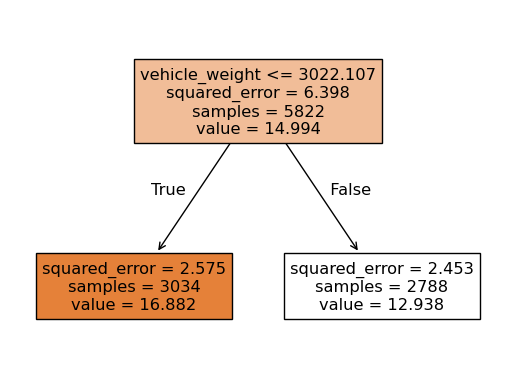

In [13]:
features = dv.get_feature_names_out()

tree.plot_tree(dt, feature_names=features, filled=True)

split_feature_index = dt.tree_.feature[0]
split_feature_name = features[split_feature_index]

print(f"The feature used for splitting the data is: {split_feature_name}")

In [14]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [15]:
rf_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
y_pred = rf_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE on the validation data: {rmse}")

RMSE on the validation data: 0.4595777223092726


In [28]:
scores = []

for n in range(10, 201, 10):
    rf_model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, rmse.round(3)))

In [29]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

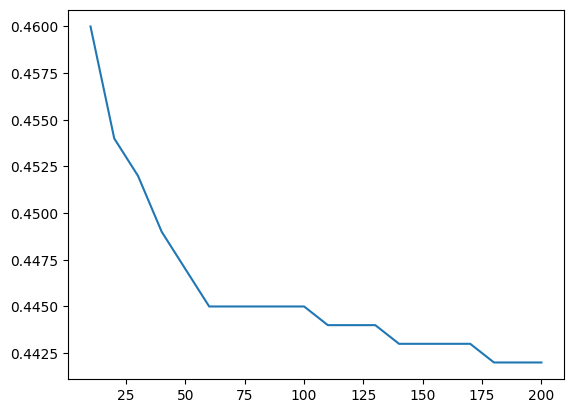

In [33]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [35]:
mean_rmse_results = {}
max_depths = [10, 15, 20, 25]

for d in max_depths:

    rmse_values = []

    for n in range(10, 201, 10):
        rf_model = RandomForestRegressor(n_estimators=n, 
                                    max_depth=d,
                                    random_state=1,
                                    n_jobs=-1)
        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_values.append(rmse)

    mean_rmse_results[d] = np.mean(rmse_values)


In [37]:
for max_depth, mean_rmse in mean_rmse_results.items():
    print(f"max_depth = {max_depth}, Mean RMSE = {mean_rmse:.3f}")

best_max_depth = min(mean_rmse_results, key=mean_rmse_results.get)
print(f"The best max_depth is: {best_max_depth} with Mean RMSE = {mean_rmse_results[best_max_depth]:.3f}")

max_depth = 10, Mean RMSE = 0.442
max_depth = 15, Mean RMSE = 0.445
max_depth = 20, Mean RMSE = 0.446
max_depth = 25, Mean RMSE = 0.446
The best max_depth is: 10 with Mean RMSE = 0.442


In [45]:
rf_model = RandomForestRegressor(n_estimators=10, 
                                    max_depth=20,
                                    random_state=1,
                                    n_jobs=-1)
rf_model.fit(X_train, y_train)

feature_importances = rf_model.feature_importances_

feature_names = dv.get_feature_names_out()

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

most_important_feature = importance_df.iloc[0]
print(f"The most important feature is: {most_important_feature['Feature']} with importance {most_important_feature['Importance']:.4f}")

The most important feature is: vehicle_weight with importance 0.9591


In [47]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features.tolist())

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [52]:
xgb_params = {
    #'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [56]:
eta_values = [0.3, 0.1]

rmse_results = {}

for eta in eta_values:
    xgb_params['eta'] = eta  
    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
    y_pred = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_results[eta] = rmse
    
    print(f"RMSE for eta={eta}: {rmse:.4f}")

[0]	train-rmse:1.81393	val-rmse:1.85444


[1]	train-rmse:1.31919	val-rmse:1.35353
[2]	train-rmse:0.98120	val-rmse:1.01316
[3]	train-rmse:0.75443	val-rmse:0.78667
[4]	train-rmse:0.60680	val-rmse:0.64318
[5]	train-rmse:0.51381	val-rmse:0.55664
[6]	train-rmse:0.45470	val-rmse:0.50321
[7]	train-rmse:0.41881	val-rmse:0.47254
[8]	train-rmse:0.39534	val-rmse:0.45509
[9]	train-rmse:0.38038	val-rmse:0.44564
[10]	train-rmse:0.37115	val-rmse:0.43896
[11]	train-rmse:0.36361	val-rmse:0.43594
[12]	train-rmse:0.35850	val-rmse:0.43558
[13]	train-rmse:0.35365	val-rmse:0.43394
[14]	train-rmse:0.35025	val-rmse:0.43349
[15]	train-rmse:0.34666	val-rmse:0.43362
[16]	train-rmse:0.34459	val-rmse:0.43378
[17]	train-rmse:0.34128	val-rmse:0.43405
[18]	train-rmse:0.33822	val-rmse:0.43391
[19]	train-rmse:0.33709	val-rmse:0.43374
[20]	train-rmse:0.33553	val-rmse:0.43376
[21]	train-rmse:0.33243	val-rmse:0.43453
[22]	train-rmse:0.33031	val-rmse:0.43510
[23]	train-rmse:0.32815	val-rmse:0.43601
[24]	train-rmse:0.32670	val-rmse:0.43592
[25]	train-rmse:0.32268	v

In [57]:
best_eta = min(rmse_results, key=rmse_results.get)
print(f"The best eta value is: {best_eta} with RMSE = {rmse_results[best_eta]:.4f}")

The best eta value is: 0.1 with RMSE = 0.4262
